In [39]:
import pandas as pd
from hs_gimme.db_facade.db_facade_factory import get_mongo_client_db
import matplotlib.pyplot as plt
from hs_gimme.logging_service.problems_only_logging_service import ProblemsOnlyLoggingService
from hs_gimme.db_facade.db_facade_factory import get_mongo_client_db
from hs_recommendations_api_client import get_recommendations_api_client
from tqdm import tqdm
from json2html import *
from hs_gimme.s3.resume_storage import ResumeStorage
from hs_gimme.hs_object_functions.application import get_selected_resume
from hs_gimme.constants.objects.application import ResumeData
import logging
import pandas as pd
import logging
from sklearn.metrics import roc_auc_score
from IPython.core.display import display, HTML
from hs_tree_blenders_creation.batch_runners.data_sets import get_account_test_set

/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_35811/1126730538.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
logger = logging.getLogger()

In [3]:
env = 'production_qa'

In [4]:
df = pd.read_csv('/Users/dima/hiredscore/brain_models_creation/tree_blenders/hs_tree_blenders_creation/fast_fetch/results/data_from_ondemand.csv')

In [7]:
for f in ['account_id', 'req_top_category', 'req_seniority_level', 'req_job_education']:
    df[f] = df[f].apply(lambda s: s.replace("['", '').replace("', '-ALL-']", ''))

In [8]:
df.head()

,Unnamed: 0.1,Unnamed: 0,account_id,req_id,current_talent_id,filter,group_name,predicted,order,is_positive,req_english_job_title,req_job_education,req_management_level,req_min_years_of_relevant_experience,req_seniority_level,req_top_category,req_sub_category
0,0,0,alabama,ABV1905074,7e7f6b7c-8b52-496b-beae-6ecd78e8d764,ALL,Negative Rejected,1,0.0,False,"2020 Clinical Trial Operations, Development Pr...",bachelors,Entry Level,NONE,entry_level,Medical,Clinical_Research
1,1,1,alabama,ABV1905074,32e3636d-19c5-4997-a5ef-81d749515bf2,ALL,Negative Rejected,0,NaN,False,"2020 Clinical Trial Operations, Development Pr...",bachelors,Entry Level,NONE,entry_level,Medical,Clinical_Research
2,2,2,alabama,ABV1905074,552e7aa3-6ac5-4a50-a12a-743bf5f54228,ALL,Positive Offer+ With Experience,1,1.0,True,"2020 Clinical Trial Operations, Development Pr...",bachelors,Entry Level,NONE,entry_level,Medical,Clinical_Research
3,3,3,alabama,ABV1905074,09280f9c-e9d7-4670-8f26-c0ae1a38edb4,ALL,Positive Offer+ With Experience,0,NaN,True,"2020 Clinical Trial Operations, Development Pr...",bachelors,Entry Level,NONE,entry_level,Medical,Clinical_Research
4,4,4,alabama,ABV2002962,5a204bf9-5621-401a-a111-d0bd463ab9e5,ALL,Negative Rejected,0,NaN,False,Operations Development Program (ODP),bachelors,Entry Level,NONE,junior,Business_&_Strategic_Management,General_Management


In [9]:
df['is_positive'] = df['group_name'] == 'Positive Offer+ With Experience'

In [ ]:
reqs = {}

reqs_p = [ 'english_job_title', 'job_education', 
           'management_level', 'min_years_of_relevant_experience', 
           'seniority_level', 'top_category',  'sub_category', 'job_listing',
         ] + ['city', 'address', 'country', 'job_title', 'job_department',
                                         'top_category', 'visa_requirements'] 
num_of_accounts = len(df['account_id'].unique())
for i, (account, account_df) in enumerate(df.groupby('account_id')):
    mongo = get_mongo_client_db(env, account)
    
    req_ids = list(account_df['req_id'].unique())
    print(f'{i}/{num_of_accounts} {account} {len(req_ids)} reqs')
    
    for r in mongo.req.find({'_id': {'$in': req_ids}}, reqs_p):
        reqs[r['_id']] = r

In [ ]:
for f in [ 'english_job_title', 'job_education', 'management_level', 'min_years_of_relevant_experience', 'seniority_level',
           'top_category',  'sub_category']:
    df['req_' + f] = df['req_id'].apply(lambda r: reqs[r].get(f)).fillna('NONE')

In [10]:
gb_fields = ['account_id', 'req_top_category', 'req_seniority_level', 'req_job_education']
exploded = df
for f in gb_fields:
    exploded[f] = df[f].apply(lambda x: [x, '-ALL-'])
    
for f in gb_fields:
    exploded = exploded.explode(f)

In [11]:
def alternative_roc_auc(d):
    if d['predicted'].sum() == 0:
        return None
    
    return roc_auc_score(d['is_positive'], d['order'].fillna(-1))

In [12]:



gb = exploded.groupby(gb_fields + ['group_name']).agg(recall=('predicted', 'mean'),
                                                talents=('current_talent_id', 'count')).unstack()
gb['Reqs'] = exploded.groupby(gb_fields)['req_id'].nunique()
gb['Reqs with recommendations'] = exploded[exploded['predicted'].astype(bool)].groupby(gb_fields)['req_id'].nunique()
gb['Coverage'] = gb['Reqs with recommendations']  / gb['Reqs']
gb['Pos/Neg Lift'] = gb[('recall', 'Positive Offer+ With Experience')] / gb[('recall', 'Negative Rejected')]
gb['Pos/Neg mean Auc'] = exploded.groupby(gb_fields + ['req_id']).apply(alternative_roc_auc).reset_index().groupby(gb_fields).mean()

gb

/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_35811/2949800866.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gb['Pos/Neg mean Auc'] = exploded.groupby(gb_fields + ['req_id']).apply(alternative_roc_auc).reset_index().groupby(gb_fields).mean()


recall  \
group_name                                                               Negative Rejected   
account_id req_top_category        req_seniority_level req_job_education                     
-ALL-      -ALL-                   -ALL-               -ALL-                      0.288489   
                                                       associates                 0.290618   
                                                       bachelors                  0.198316   
                                                       doctorate                  0.104839   
                                                       high_school                0.323365   
...                                                                                    ...   
tampa      Supply_Chain_Management manager             bachelors                  0.000000   
                                   senior              -ALL-                      0.833333   
                                                       bachelors                  0.500000   
                                                       masters                    1.000000   
                                                       none_required              1.000000   

                                                                                                          \
group_name                                                               Positive Offer+ With Experience   
account_id req_top_category        req_seniority_level req_job_education                                   
-ALL-      -ALL-                   -ALL-               -ALL-                                    0.383550   
                                                       associates                               0.389016   
                                                       bachelors                                0.346352   
                                                       doctorate                                0.193548   
                                                       high_school                              0.376721   
...                                                                                                  ...   
tampa      Supply_Chain_Management manager             bachelors                                1.000000   
                                   senior              -ALL-                                    0.166667   
                                                       bachelors                                0.000000   
                                                       masters                                  1.000000   
                                                       none_required                            0.000000   

                                                                                   talents  \
group_name                                                               Negative Rejected   
account_id req_top_category        req_seniority_level req_job_education                     
-ALL-      -ALL-                   -ALL-               -ALL-                         14517   
                                                       associates                      874   
                                                       bachelors                      4276   
                                                       doctorate                       124   
                                                       high_school                    4648   
...                                                                                    ...   
tampa      Supply_Chain_Management manager             bachelors                         1   
                                   senior              -ALL-                             6   
                                                       bachelors                         2   
                                                       masters                           1   
                                

In [88]:
to_save = gb[gb['Reqs'] > 50]
writer = pd.ExcelWriter("fetch_evaluation.xlsx", engine="xlsxwriter")

In [89]:
accounts_summary_cols = [(               'account_id',                                ''),
                            (                   'recall',               'Negative Rejected'),
                            (                   'recall', 'Positive Offer+ With Experience'),
                            (                  'talents',               'Negative Rejected'),
                            (                  'talents', 'Positive Offer+ With Experience'),
                            (                     'Reqs',                                ''),
                            ('Reqs with recommendations',                                ''),
                            (                 'Coverage',                                ''),
                            (             'Pos/Neg Lift',                                ''),
                            (         'Pos/Neg mean Auc',                                '')]
accounts_summary_mask = lambda x: (x['req_top_category'] == '-ALL-') & \
                 (x['req_seniority_level'] == '-ALL-') & \
                 (x['req_job_education'] == '-ALL-')
                
accounts_summary_df = to_save.reset_index()[accounts_summary_mask][accounts_summary_cols]
accounts_summary_df.to_excel(writer, sheet_name="Summary")
workbook = writer.book
worksheet = writer.sheets["Summary"]
col = list(accounts_summary_df.columns).index(('Pos/Neg Lift', '')) + 1
worksheet.conditional_format(2, col, len(accounts_summary_df) + 2, col, {"type": "3_color_scale"})
col = list(accounts_summary_df.columns).index(('Pos/Neg mean Auc', '')) + 1
worksheet.conditional_format(2, col, len(accounts_summary_df) + 2, col, {"type": "3_color_scale"})
accounts_summary_df

account_id            recall                                  \
group_name            Negative Rejected Positive Offer+ With Experience   
0               -ALL-          0.288489                        0.383550   
137           alabama          0.196689                        0.365628   
188          colorado          0.161616                        0.212121   
189             essex          0.274238                        0.304709   
195           indiana          0.104985                        0.266994   
241            moscow          0.366191                        0.411270   
295            oxford          0.383790                        0.489869   
319             tampa          0.269865                        0.410795   

                     talents                                   Reqs  \
group_name Negative Rejected Positive Offer+ With Experience          
0                      14517                           14517  11014   
137                     2054                            2054   1850   
188                       99                              99     74   
189                      361                             361    144   
195                     2648                            2648   1861   
241                     7010                            7010   5005   
295                     1678                            1678   1505   
319                      667                             667    575   

           Reqs with recommendations  Coverage Pos/Neg Lift Pos/Neg mean Auc  
group_name                                                                    
0                             6359.0  0.577356     1.329513         0.599374  
137                            889.0  0.480541     1.858911         0.682365  
188                             27.0  0.364865     1.312500         0.611111  
189                             86.0  0.597222     1.111111         0.587142  
195                            740.0  0.397636     2.543165         0.710902  
241                           3240.0  0.647353     1.123101         0.550375  
295                           1045.0  0.694352     1.276398         0.592805  
319                            332.0  0.577391     1.522222         0.629644

In [90]:
worksheet.insert_image( len(accounts_summary_df) + 5, 0, "box.png")
len(accounts_summary_df)

8

In [91]:
accounts_summary_mask = lambda x: (x['req_top_category'] != '-ALL-') & \
                 (x['req_seniority_level'] == '-ALL-') & \
                 (x['req_job_education'] == '-ALL-')
                
accounts_summary_df = to_save.reset_index()[accounts_summary_mask][accounts_summary_cols]

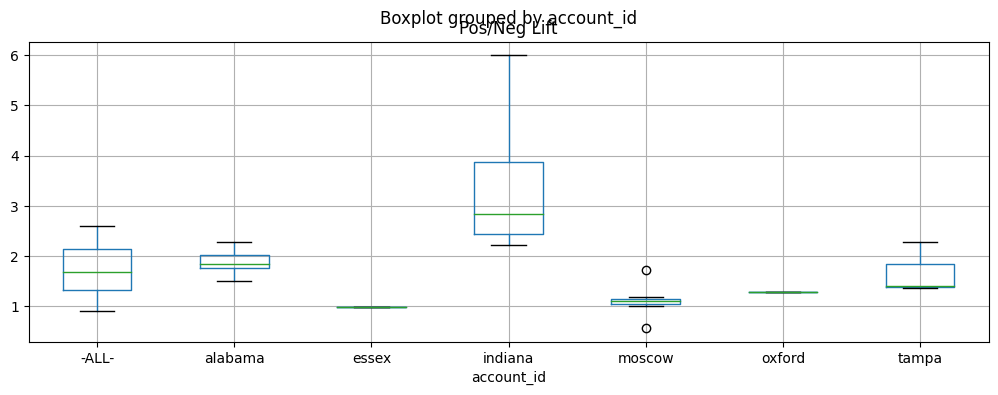

In [92]:
plot = accounts_summary_df.boxplot(by='account_id', column='Pos/Neg Lift', figsize=(12, 4))
fig = plot.get_figure()
fig.savefig("output.png")
plt.savefig("box.png")

In [93]:
to_save.reset_index().to_excel(writer, sheet_name="Details")
workbook = writer.book
worksheet = writer.sheets["Details"]
col = list(to_save.reset_index().columns).index(('Pos/Neg Lift', '')) + 1
worksheet.conditional_format(2, col, len(to_save)+2, col, {"type": "3_color_scale"})
col = list(to_save.reset_index().columns).index(('Pos/Neg mean Auc', '')) + 1
worksheet.conditional_format(2, col, len(to_save)+2, col, {"type": "3_color_scale"})

0

In [94]:
writer.close()